In [6]:
!pip install mlxtend
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

df_raw = pd.read_csv('Air_Quality_20231208.csv', header=None)

columns = [
    "id1", "id2", "pollutant_or_metric", "statistic", "unit",
    "geo_type", "geo_id", "neighborhood", "period", "date", "value", "message"
]

df_raw.columns = columns
df = df_raw   # optional alias
df.head()

,id1,id2,pollutant_or_metric,statistic,unit,geo_type,geo_id,neighborhood,period,date,value,message
0,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
1,172653,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,203,Bedford Stuyvesant - Crown Heights,Annual Average 2011,12/01/2010,25.3,NaN
2,172585,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,203,Bedford Stuyvesant - Crown Heights,Annual Average 2009,12/01/2008,26.93,NaN
3,336637,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,204,East New York,Annual Average 2015,01/01/2015,19.09,NaN
4,336622,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,103,Fordham - Bronx Pk,Annual Average 2015,01/01/2015,19.76,NaN


In [7]:
asthma_mask = df["pollutant_or_metric"].str.contains("Asthma", na=False)
no2_mask = df["pollutant_or_metric"] == "Nitrogen dioxide (NO2)"
pm25_mask = df["pollutant_or_metric"] == "Fine particles (PM 2.5)"
o3_mask = df["pollutant_or_metric"] == "Ozone (O3)"

In [8]:
records = []

for idx, row in df[no2_mask | pm25_mask | o3_mask | asthma_mask].iterrows():
    records.append({
        "geo_id": row["geo_id"],
        "date": pd.to_datetime(row["date"]),
        "type": row["pollutant_or_metric"],
        "value": row["value"]
    })

df_clean = pd.DataFrame(records)
df_clean

,geo_id,date,type,value
0,203,2010-12-01,Nitrogen dioxide (NO2),25.3
1,203,2008-12-01,Nitrogen dioxide (NO2),26.93
2,204,2015-01-01,Nitrogen dioxide (NO2),19.09
3,103,2015-01-01,Nitrogen dioxide (NO2),19.76
4,104,2008-12-01,Nitrogen dioxide (NO2),22.83
...,...,...,...,...
14119,5,2017-12-01,Nitrogen dioxide (NO2),18.92
14120,205,2014-06-01,Ozone (O3),30.6
14121,205,2008-12-01,Nitrogen dioxide (NO2),30.17
14122,205,2013-12-01,Nitrogen dioxide (NO2),27.68


In [9]:
df_clean["type"].value_counts()

type
Nitrogen dioxide (NO2)                              5499
Fine particles (PM 2.5)                             5499
Ozone (O3)                                          1974
Asthma emergency department visits due to PM2.5      384
Asthma hospitalizations due to Ozone                 384
Asthma emergency departments visits due to Ozone     384
Name: count, dtype: int64

In [12]:
type_map = {
    "Nitrogen dioxide (NO2)": "NO2",
    "Fine particles (PM 2.5)": "PM25",
    "Ozone (O3)": "O3",
    "Asthma emergency department visits due to PM2.5": "ASTHMA",
    "Asthma hospitalizations due to Ozone": "ASTHMA",
    "Asthma emergency departments visits due to Ozone": "ASTHMA"
}
df_clean["type"] = df_clean["type"].map(type_map)

In [14]:
df_clean["value"] = pd.to_numeric(df_clean["value"], errors="coerce")
print("NaNs after conversion:", df_clean["value"].isna().sum())
df_clean = df_clean.dropna(subset=["value"])

# Treat each record as a transaction
df_wide = df_clean.pivot_table(
    index=["geo_id", "date"],
    columns="type",
    values="value",
    aggfunc="mean"  # If multiple rows share the same type, compute the mean
).reset_index()

NaNs after conversion: 0


In [15]:
df_valid = df_wide.dropna(subset=["ASTHMA"]).copy() # 
asthma_median = df_valid["ASTHMA"].median()
df_valid["ASTHMA_HIGH"] = (df_valid["ASTHMA"] > asthma_median).astype(int)


pollutants = ["NO2", "PM25", "O3"]
df_valid[pollutants] = df_valid[pollutants].fillna(df_valid[pollutants].median())
for col in pollutants:
    med = df_valid[col].median()
    df_valid[f"{col}_HIGH"] = (df_valid[col] > med).astype(int)

In [16]:
df_wide = df_valid.copy()

In [17]:
# Boolean transformation for Apriori
apriori_df = df_wide[["NO2_HIGH", "PM25_HIGH", "O3_HIGH", "ASTHMA_HIGH"]].astype(bool)

# Apriori association rule mining
frequent_itemsets = apriori(apriori_df, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

In [18]:
# Filter rules where ASTHMA_HIGH appears in the consequent (focus on pollution → asthma risk)
rules_asthma = rules[rules['consequents'].apply(lambda x: 'ASTHMA_HIGH' in x)]

In [19]:
print("\n=== Association Rules (Sorted by Lift) ===")
print(
    rules_asthma[
        ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    ].sort_values('lift', ascending=False)
)


=== Association Rules (Sorted by Lift) ===
  antecedents    consequents  support  confidence      lift
2  (NO2_HIGH)  (ASTHMA_HIGH)  0.06383    0.521739  1.043478


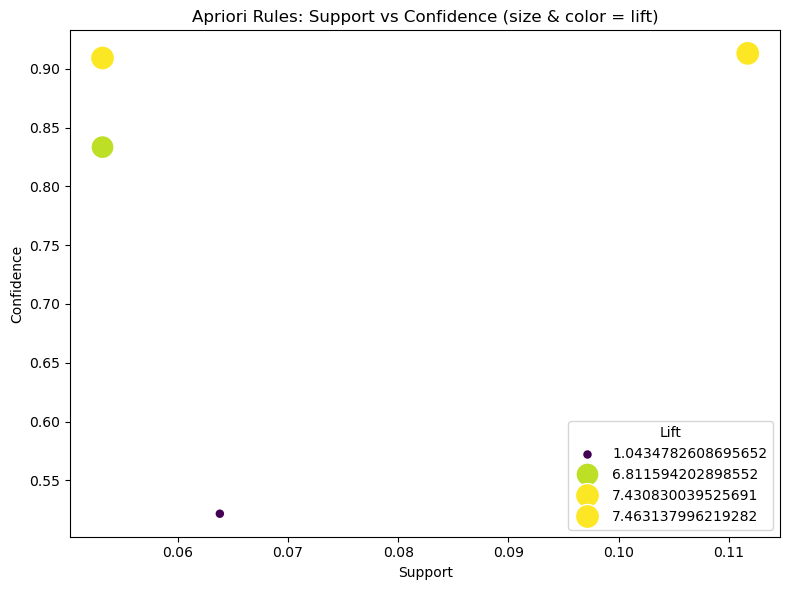

In [20]:
# Visualization: Support vs Confidence
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rules,
    x='support',
    y='confidence',
    size='lift',
    sizes=(50, 300),
    hue='lift',
    palette='viridis'
)
plt.title('Apriori Rules: Support vs Confidence (size & color = lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(title='Lift')
plt.tight_layout()
plt.savefig("apriori_scatter.png", dpi=150)
plt.show()

In [21]:
X = df_wide[["NO2_HIGH", "PM25_HIGH", "O3_HIGH"]]
y = df_wide["ASTHMA_HIGH"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\n=== Decision Tree Classification Results ===")
print(f"Accuracy: {acc:.3f}")
print("Confusion Matrix:")
print(cm)


=== Decision Tree Classification Results ===
Accuracy: 0.509
Confusion Matrix:
[[29  0]
 [28  0]]


In [22]:
# Clustering Analysis: K-means on NO2, PM2.5, O3 (raw continuous values)
cluster_features = ["NO2", "PM25", "O3"]

df_cluster = df_wide.dropna(subset=cluster_features, how="all").copy()

if len(df_cluster) == 0:
    raise ValueError("No valid pollutant data available for clustering!")

# Fill missing values in each pollutant column using its median
for col in cluster_features:
    if df_cluster[col].isnull().any():
        median_val = df_cluster[col].median()
        if pd.isna(median_val):
            print(f"The entire column {col} is missing. Filling with 0.")
            median_val = 0
        df_cluster[col].fillna(median_val, inplace=True)

# Extract feature matrix
X = df_cluster[cluster_features].values

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering (k = 3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Assign cluster labels back to the dataframe
df_cluster["cluster"] = cluster_labels

# Compute mean pollutant concentrations for each cluster (in original units)
cluster_summary = df_cluster.groupby("cluster")[cluster_features].mean()

print("\n=== Clustering Results (Mean Pollutant Levels in Original Units) ===")
print(cluster_summary.round(2))

# Rank clusters by total pollution level
cluster_summary["total"] = cluster_summary.sum(axis=1)
cluster_summary_sorted = cluster_summary.sort_values("total", ascending=False)

# Assign descriptive names to clusters
cluster_name_map = {}
for rank, (cluster_id, _) in enumerate(cluster_summary_sorted.iterrows()):
    if rank == 0:
        cluster_name_map[cluster_id] = "High Pollution Group"
    elif rank == 2:
        cluster_name_map[cluster_id] = "Low Pollution Group"
    else:
        cluster_name_map[cluster_id] = "Medium Pollution Group"

print("\nCluster Interpretation:")
for i in range(3):
    name = cluster_name_map[i]
    row = cluster_summary.loc[i]
    print(
        f"Cluster {i}: {name} — "
        f"NO₂ = {row['NO2']:.2f}, "
        f"PM2.5 = {row['PM25']:.2f}, "
        f"O₃ = {row['O3']:.2f}"
    )

The entire column O3 is missing. Filling with 0.


C:\Users\yidaf\AppData\Local\Temp\ipykernel_25684\4247357253.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cluster[col].fillna(median_val, inplace=True)



=== Clustering Results (Mean Pollutant Levels in Original Units) ===
type       NO2   PM25   O3
cluster                   
0        20.81   9.35  0.0
1        16.96   8.07  0.0
2        25.48  10.44  0.0

Cluster Interpretation:
Cluster 0: Medium Pollution Group — NO₂ = 20.81, PM2.5 = 9.35, O₃ = 0.00
Cluster 1: Low Pollution Group — NO₂ = 16.96, PM2.5 = 8.07, O₃ = 0.00
Cluster 2: High Pollution Group — NO₂ = 25.48, PM2.5 = 10.44, O₃ = 0.00


D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
